<a href="https://colab.research.google.com/github/KingYuanSun/Individual-Projects-Finance/blob/master/StockPrediction_basicRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted by Carlos Toxtli http://www.carlostoxtli.com/#colab-stock-1

Credits: https://github.com/Kulbear/stock-prediction

In [24]:
!git clone https://github.com/Kulbear/stock-prediction
%cd stock-prediction

Cloning into 'stock-prediction'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34
Unpacking objects: 100% (34/34), done.
/content/stock-prediction/stock-prediction


# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [25]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Import Data

I have introduced how we get this dataset both in README.md and in another notebook.

In [26]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. "Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." Read [here](http://stackoverflow.com/a/43526354/6670143) for more detailed explanation.

In [27]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [28]:
def recover_scaler(train_orig, test_orig, X_train, X_test, predictions_for_inverse_transform):

    train_orig_samples, train_orig_nx, train_orig_ny = train_orig.shape
    
    train_orig = train_orig.reshape((train_orig_samples, train_orig_nx * train_orig_ny))

    preprocessor = prep.StandardScaler().fit(train_orig)


    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    predictions_for_inverse_transform_samples, predictions_for_inverse_transform_nx, predictions_for_inverse_transform_ny = predictions_for_inverse_transform.shape
    
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    predictions_for_inverse_transform = predictions_for_inverse_transform.reshape((predictions_for_inverse_transform_samples, predictions_for_inverse_transform_nx * predictions_for_inverse_transform_ny))
    
    # print (X_test)
    # print (predictions_for_inverse_transform)

    X_train = preprocessor.inverse_transform(X_train)
    X_test = preprocessor.inverse_transform(X_test)
    predictions_for_inverse_transform = preprocessor.inverse_transform(predictions_for_inverse_transform)    

    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    predictions_for_inverse_transform = predictions_for_inverse_transform.reshape((predictions_for_inverse_transform_samples, predictions_for_inverse_transform_nx, predictions_for_inverse_transform_ny))

    return X_train, X_test, predictions_for_inverse_transform

Split the data to X_train, y_train, X_test, y_test

In [29]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    ## Probably here add another column as the label.
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])

        # print (index)

        # print (result)
    
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]

    print (train)
    print (result)
    # # print (row)
    # print ("X_train")
    # print (train[:, : -1])
    # print ("y_train")
    # print (train[:, -1][: ,-1]) 

    # print ("X_test")
    # print (result[int(row) :, : -1]) 
    # print ("y_test")
    print (result[int(row) :, -1][ : ,-1]) 

    # trainFit = StandardScaler().fit(train)
    # resultFit = StandardScaler().fit(result)
    # train = trainFit.transform(train)
    # result = resultFit.transform(result)

    train_standard, result_standard = standard_scaler(train, result)

    
    X_train = train_standard[:, : -1]
    y_train = train_standard[:, -1][: ,-1]
    X_test = result_standard[int(row) :, : -1]
    y_test = result_standard[int(row) :, -1][ : ,-1]

    print (y_test)



    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features)) 

 

    return [X_train, y_train, X_test, y_test, train, result,train_standard,result_standard]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [30]:
def build_model(layers):

    model = Sequential()
    model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1, activation='linear'))

    start = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary() 
    print("Compilation Time : ", time.time() - start)
    return model

In [31]:
window = 20
X_train, y_train, X_test, y_test, train_orig, result_orig, train_for_inverse_transform,result_for_inverse_transform = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# print (X_train)
# print (y_train)
# print (X_test)
# print (y_test)

[[[6.03000000e+00 6.19000000e+00 5.85000000e+00 3.78800000e+05
   2.28317000e+06 6.17000000e+00]
  [6.20000000e+00 6.31000000e+00 6.06000000e+00 5.44600000e+05
   3.38570500e+06 6.26000000e+00]
  [6.26000000e+00 6.35000000e+00 6.12000000e+00 5.60400000e+05
   3.49940500e+06 6.15000000e+00]
  ...
  [5.55000000e+00 5.62000000e+00 5.50000000e+00 1.50900000e+05
   8.41633000e+05 5.57000000e+00]
  [5.50000000e+00 5.60000000e+00 5.45000000e+00 1.57300000e+05
   8.70136000e+05 5.55000000e+00]
  [5.60000000e+00 5.61000000e+00 5.52000000e+00 8.88000000e+04
   4.94768000e+05 5.56000000e+00]]

 [[6.20000000e+00 6.31000000e+00 6.06000000e+00 5.44600000e+05
   3.38570500e+06 6.26000000e+00]
  [6.26000000e+00 6.35000000e+00 6.12000000e+00 5.60400000e+05
   3.49940500e+06 6.15000000e+00]
  [6.08000000e+00 6.18000000e+00 6.02000000e+00 4.62600000e+05
   2.82735100e+06 6.18000000e+00]
  ...
  [5.50000000e+00 5.60000000e+00 5.45000000e+00 1.57300000e+05
   8.70136000e+05 5.55000000e+00]
  [5.60000000e+0

In [32]:
model = build_model([X_train.shape[2], window, 100, 1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 512)           1062912   
_________________________________________________________________
dropout (Dropout)            (None, 20, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 64)            4

## Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [33]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=200,
    validation_split=0.1,
    verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [34]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.08 RMSE)
Test Score: 0.03 MSE (0.17 RMSE)


## Visualize the Prediction

In [35]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [36]:
# TODO: Scale it back

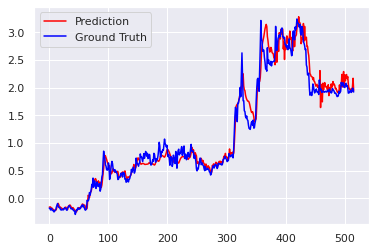

In [37]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2


plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

b
[ 9.38  9.4   9.21  9.33  9.35  9.16  9.16  9.16  9.02  9.12  9.17  9.25
  9.5   9.67  9.83  9.62  9.46  9.44  9.44  9.25  9.21  9.27  9.23  9.28
  9.22  9.33  9.44  9.39  9.33  9.22  9.18  9.44  9.47  9.57  9.64  9.51
  9.41  9.31  9.35  9.35  9.22  9.2   9.1   9.09  8.78  9.02  9.22  9.18
  9.4   9.3   9.39  9.29  9.33  9.4   9.58  9.6   9.71  9.51  9.67  9.47
  9.29  9.19  9.24  9.37 10.15 10.08 10.1  10.27 10.9  10.64 10.93 11.2
 11.69 11.46 12.3  11.42 11.95 12.03 11.69 11.3  11.53 11.93 11.62 11.48
 11.72 11.75 11.03 11.22 11.78 12.43 12.64 13.9  14.91 14.36 14.23 13.59
 13.45 13.12 13.07 13.1  13.77 13.52 12.17 12.35 13.05 13.58 13.92 13.7
 13.18 13.   13.01 13.12 12.88 12.96 12.8  12.7  12.16 12.18 12.42 12.41
 12.47 12.76 12.64 12.77 12.4  12.85 12.75 12.77 12.2  12.22 11.9  11.94
 12.22 12.02 11.93 12.22 12.23 12.49 12.63 13.14 12.87 13.14 13.36 13.05
 12.78 12.95 13.35 14.24 13.82 13.72 13.59 13.45 13.72 13.82 14.64 14.32
 14.37 14.12 13.9  14.3  14.67 14.21 14.48 14.88 14

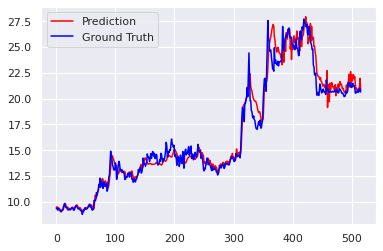

In [38]:

row = round(0.9 * result_for_inverse_transform.shape[0])
# print (result_for_inverse_transform[int(row) :, -1][ : ,-1])
import copy

predictions_for_inverse_transform = copy.deepcopy(result_for_inverse_transform)

#print (pred)
for i in range(len(pred)):
  predictions_for_inverse_transform[int(row) :, -1][ i ,-1] = pred[i]

# print (predictions_for_inverse_transform[int(row) :, -1][ : ,-1])

a,b,c =  recover_scaler(train_orig, result_orig, train_for_inverse_transform, result_for_inverse_transform, predictions_for_inverse_transform)
recovered_stock_true_price = b[int(row) :, -1][ : ,-1]
recovered_stock_pred_price = c[int(row) :, -1][ : ,-1]
# print (result_orig[int(row) :, -1][ : ,-1])
print ("b")
print (b[int(row) :, -1][ : ,-1])
print ("c")
print (c[int(row) :, -1][ : ,-1])

plt2.plot(recovered_stock_pred_price, color='red', label='Prediction')
plt2.plot(recovered_stock_true_price, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

turtle-agent

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [40]:
from pandas import DataFrame
df = DataFrame (recovered_stock_true_price,columns=['Close'])
print (df)

     Close
0     9.38
1     9.40
2     9.21
3     9.33
4     9.35
..     ...
511  20.60
512  20.70
513  21.02
514  20.94
515  20.64

[516 rows x 1 columns]


duel-curiosity-q-learning-agent

In [41]:
from collections import deque
import random

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.layers.dense(state_action, 32, activation=tf.nn.relu)
            self.curiosity_logits = tf.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                x_action = tf.layers.dense(self.X, 128, tf.nn.relu)
                tensor_action, tensor_validation = tf.split(x_action,2,1)
                feed_action = tf.layers.dense(tensor_action, self.OUTPUT_SIZE)
                feed_validation = tf.layers.dense(tensor_validation, 1)
                self.logits = feed_validation + \
                tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            
            with tf.variable_scope("target_net"):
                y_action = tf.layers.dense(self.Y, 128, tf.nn.relu)
                tensor_action, tensor_validation = tf.split(y_action,2,1)
                feed_action = tf.layers.dense(tensor_action, self.OUTPUT_SIZE)
                feed_validation = tf.layers.dense(tensor_validation, 1)
                y_q = feed_validation + \
                tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [42]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 101.890000.3, cost: 4.251310, total money: 9914.370000
epoch: 20, total rewards: 137.200000.3, cost: 11.890570, total money: 9504.830000
epoch: 30, total rewards: 191.920000.3, cost: 18.548607, total money: 9836.620000
epoch: 40, total rewards: 120.680000.3, cost: 176.272781, total money: 10058.480000
epoch: 50, total rewards: 206.380000.3, cost: 114.700272, total money: 9769.330000
epoch: 60, total rewards: 35.330000.3, cost: 56.959476, total money: 10035.330000
epoch: 70, total rewards: 63.850000.3, cost: 294.620178, total money: 10022.550000
epoch: 80, total rewards: 88.580000.3, cost: 234.772568, total money: 9462.900000
epoch: 90, total rewards: 480.990000.3, cost: 170.372574, total money: 9526.150000
epoch: 100

In [43]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 9.400000, total balance 9990.600000
day 2: buy 1 unit at price 9.210000, total balance 9981.390000
day 3, sell 1 unit at price 9.330000, investment -0.744681 %, total balance 9990.720000,
day 4, sell 1 unit at price 9.350000, investment 1.520087 %, total balance 10000.070000,
day 5: buy 1 unit at price 9.160000, total balance 9990.910000
day 7, sell 1 unit at price 9.160000, investment 0.000000 %, total balance 10000.070000,
day 8: buy 1 unit at price 9.020000, total balance 9991.050000
day 10: buy 1 unit at price 9.170000, total balance 9981.880000
day 13: buy 1 unit at price 9.670000, total balance 9972.210000
day 14, sell 1 unit at price 9.830000, investment 8.980044 %, total balance 9982.040000,
day 15, sell 1 unit at price 9.620000, investment 4.907306 %, total balance 9991.660000,
day 16, sell 1 unit at price 9.460000, investment -2.171665 %, total balance 10001.120000,
day 28: buy 1 unit at price 9.330000, total balance 9991.790000
day 29, sell 1 unit 

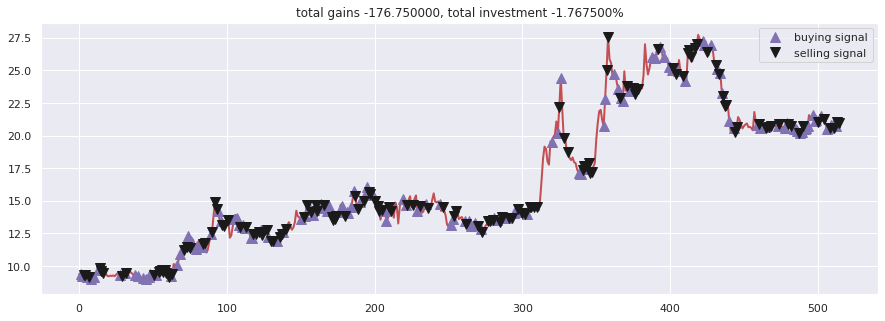

In [44]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()
